###  VAE/GAN

In [58]:
import numpy as np 
#import imageio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import glob
import PIL
import time
from IPython import display
import os

### Creating a sampling layer

In [38]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var)* epsilon

### Building the encoder

In [39]:
latent_dim = 2
encoder_inputs = keras.Input(shape = (28,28,1))
x = layers.Conv2D(32,3, activation='relu', strides = 2, padding = "same")(encoder_inputs)
x = layers.Conv2D(64,3, activation='relu', strides = 2, padding = "same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16,activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name = 'z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs,[z_mean,z_log_var,z], name = "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

### Building the decoder

In [40]:
latent_inputs = keras.Input(shape = (latent_dim,))
x = layers.Dense(7*7*64,activation = "relu")(latent_inputs)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(64,3,activation = "relu", strides = 2, padding = "same")(x)
x = layers.Conv2DTranspose(32,3,activation = "relu",strides = 2, padding = "same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

### Define the VAE as a Model with a custom training step 

In [41]:
class VAE(keras.Model):
    def __init__(self, encoder,decoder, **kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def train_step(self,data):
        if isinstance(data,tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data,reconstruction))
            reconstruction_loss *= 28*28
            k1_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            k1_loss = tf.reduce_mean(k1_loss)
            k1_loss *= -0.5
            total_loss = reconstruction_loss + k1_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return{
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "k1_loss": k1_loss,
        }

### Training the VAE

In [42]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)


Epoch 1/30
547/547 [==============================] - 24s 43ms/step - loss: 209.1152 - reconstruction_loss: 207.1295 - k1_loss: 1.9857
Epoch 2/30
547/547 [==============================] - 24s 44ms/step - loss: 171.3550 - reconstruction_loss: 168.7623 - k1_loss: 2.5927
Epoch 3/30
547/547 [==============================] - 24s 43ms/step - loss: 159.5388 - reconstruction_loss: 156.5623 - k1_loss: 2.9765
Epoch 4/30
547/547 [==============================] - 24s 45ms/step - loss: 155.9963 - reconstruction_loss: 152.8782 - k1_loss: 3.1181
Epoch 5/30
547/547 [==============================] - 24s 44ms/step - loss: 154.2668 - reconstruction_loss: 151.0614 - k1_loss: 3.2054
Epoch 6/30
547/547 [==============================] - 24s 44ms/step - loss: 152.9312 - reconstruction_loss: 149.6678 - k1_loss: 3.2634
Epoch 7/30
547/547 [==============================] - 23s 43ms/step - loss: 151.9262 - reconstruction_loss: 148.6128 - k1_loss: 3.3134
Epoch 8/30
547/547 [==============================] - 2

### Display a grid of sampled digits

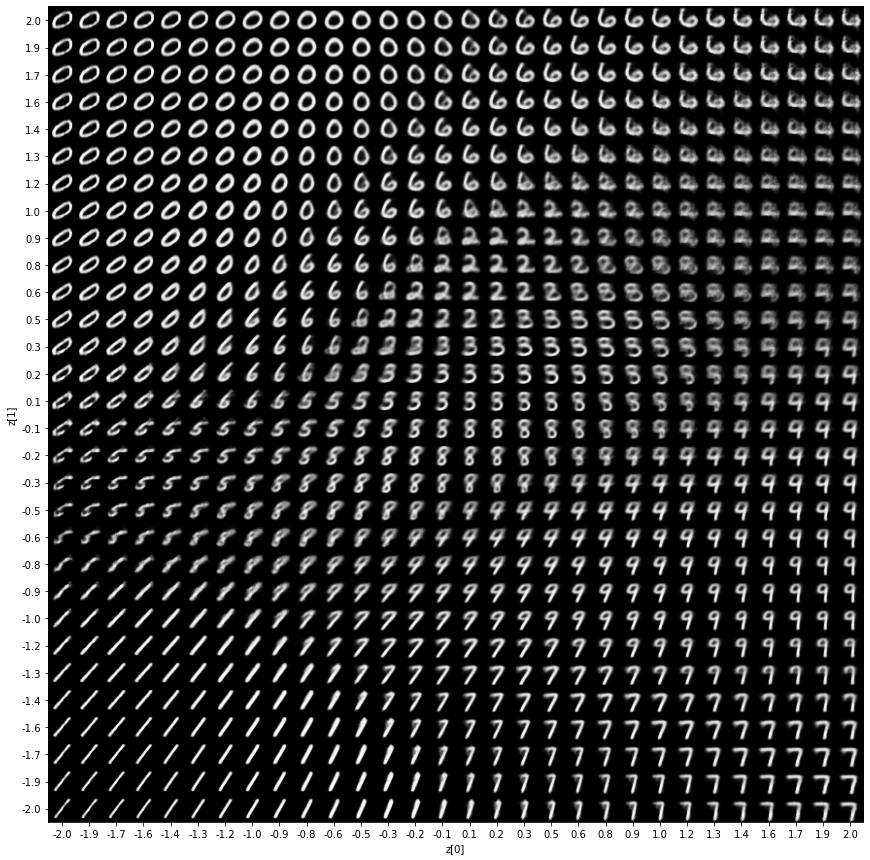

In [43]:
def plot_latent(encoder,decoder):
    #display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size *n))
    #linearly spaced coordinates corresponding to the 2D plot of digit classes in the latent space
    grid_x = np.linspace(-scale,scale,n)
    grid_y = np.linspace(-scale,scale,n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j,xi in enumerate(grid_x):
            z_sample = np.array([[xi,yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i* digit_size:(i+1) * digit_size,
                j*digit_size:(j+1) * digit_size
            ]= digit
            
    plt.figure(figsize=(figsize,figsize))
    start_range = digit_size//2
    end_range = n*digit_size+start_range +1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x,1)
    sample_range_y = np.round(grid_y,1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure,cmap = "Greys_r")
    plt.show()

plot_latent(encoder,decoder)

### Displaying how the latent space clusters different digit classes

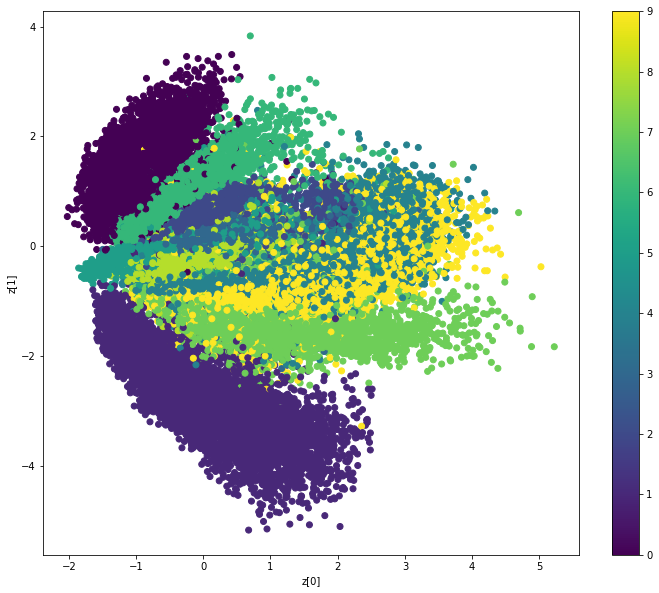

In [44]:
def plot_label_clusters(encoder,decoder,data,labels):
    #display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12,10))
    plt.scatter(z_mean[:,0],z_mean[:,1],c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)

### GAN// Following tensorflow tutorial 

### data perparation

In [49]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Creating the model : The generator, layers to produce an image from a seed (random noise)

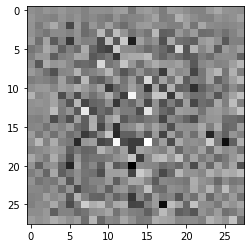

In [50]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

#Use the  generator to create an image.

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator; The discriminator is a CNN-based image classifier

In [51]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

#Using discriminator to classify weither the generated images are real or fake. the models 
#will be trained to output positive values for real images, and neagative values for fake images. 

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0001854]], shape=(1, 1), dtype=float32)


### Defining the loss and optimizers for both models


In [69]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# disctiminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#we need to train the models saparately since the discriminator and the generator loss are different
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#defining the training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

    # Produce images for the GIF as we go
    #display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
     if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### Generate and save images


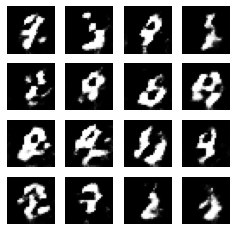

Time for epoch 1 is 129.44162607192993 sec


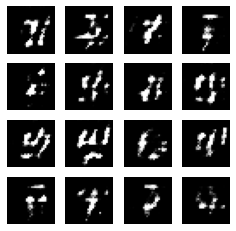

Time for epoch 2 is 131.73365879058838 sec


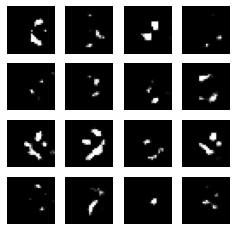

Time for epoch 3 is 126.63106346130371 sec


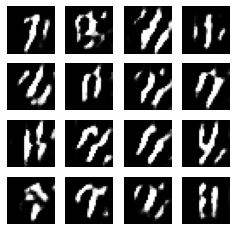

Time for epoch 4 is 125.84818530082703 sec


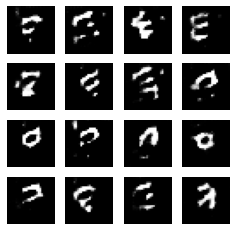

Time for epoch 5 is 125.99220037460327 sec


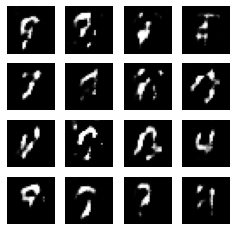

Time for epoch 6 is 125.77076983451843 sec


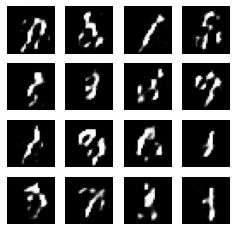

Time for epoch 7 is 125.67470383644104 sec


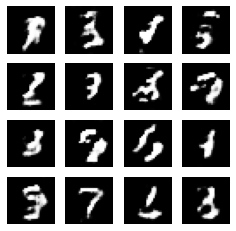

Time for epoch 8 is 125.66202139854431 sec


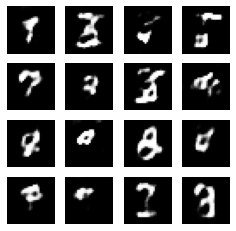

Time for epoch 9 is 125.71052837371826 sec


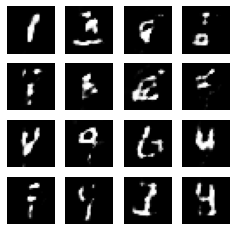

Time for epoch 10 is 125.73540210723877 sec


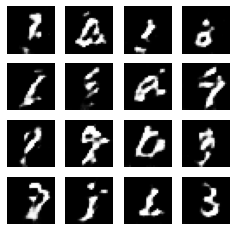

Time for epoch 11 is 125.78977131843567 sec


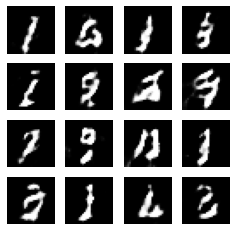

Time for epoch 12 is 125.63901257514954 sec


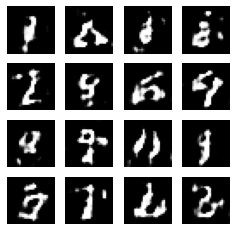

Time for epoch 13 is 125.73261260986328 sec


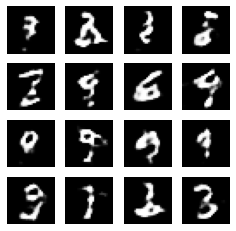

Time for epoch 14 is 125.71718764305115 sec


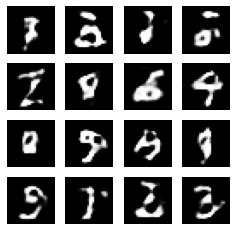

Time for epoch 15 is 125.76513624191284 sec


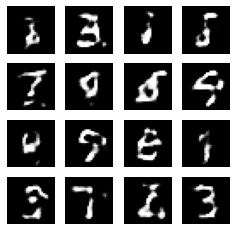

Time for epoch 16 is 125.67487382888794 sec


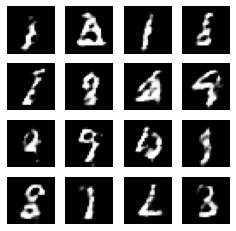

Time for epoch 17 is 125.62572646141052 sec


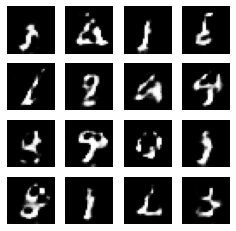

Time for epoch 18 is 125.95625185966492 sec


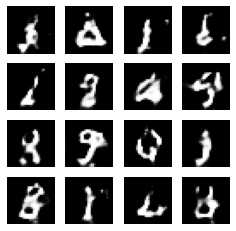

Time for epoch 19 is 125.61852192878723 sec


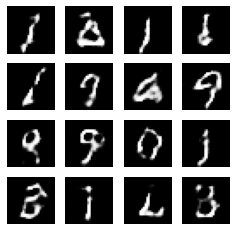

Time for epoch 20 is 125.58368396759033 sec


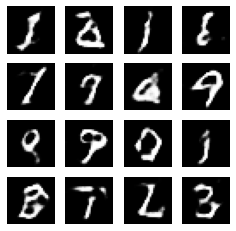

Time for epoch 21 is 125.68711137771606 sec


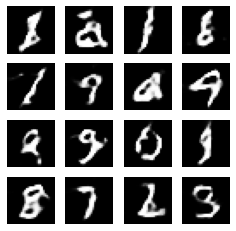

Time for epoch 22 is 125.72631669044495 sec


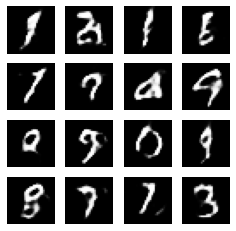

Time for epoch 23 is 125.62407279014587 sec


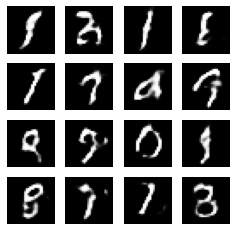

Time for epoch 24 is 125.78754234313965 sec


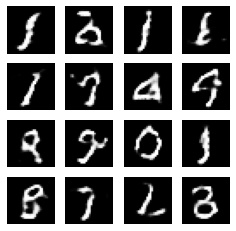

Time for epoch 25 is 125.85481262207031 sec


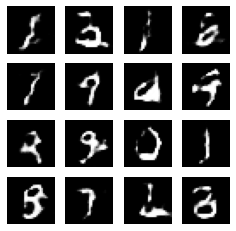

Time for epoch 26 is 125.72948026657104 sec


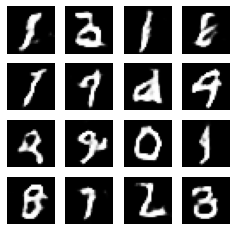

Time for epoch 27 is 125.66697311401367 sec


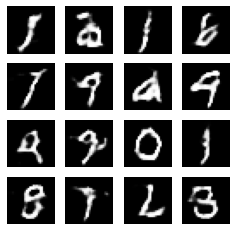

Time for epoch 28 is 125.78228855133057 sec


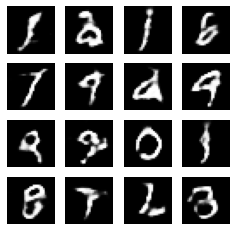

Time for epoch 29 is 125.72781205177307 sec


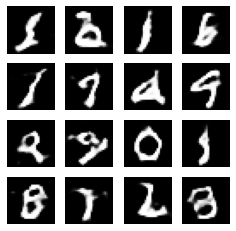

Time for epoch 30 is 125.74556565284729 sec


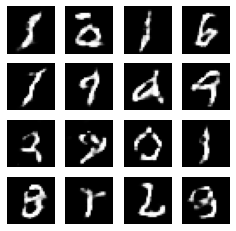

Time for epoch 31 is 126.00364232063293 sec


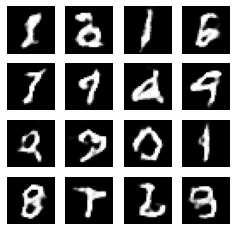

Time for epoch 32 is 125.85541439056396 sec


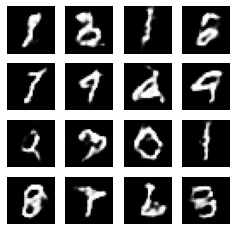

Time for epoch 33 is 125.67753338813782 sec


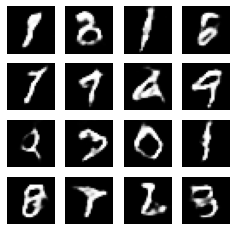

Time for epoch 34 is 125.77162432670593 sec


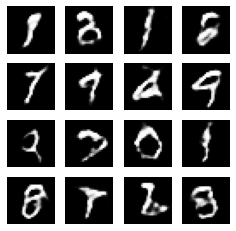

Time for epoch 35 is 125.68139171600342 sec


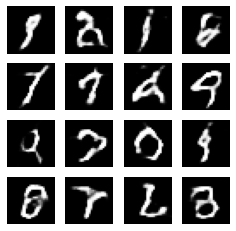

Time for epoch 36 is 125.64778995513916 sec


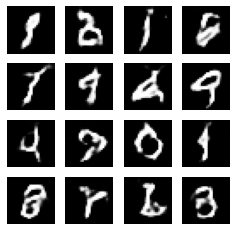

Time for epoch 37 is 125.74967169761658 sec


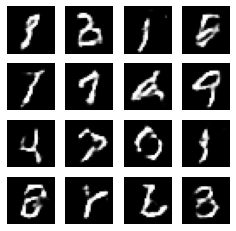

Time for epoch 38 is 125.73028707504272 sec


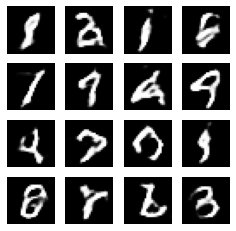

Time for epoch 39 is 125.65301537513733 sec


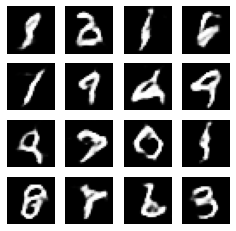

Time for epoch 40 is 125.77560377120972 sec


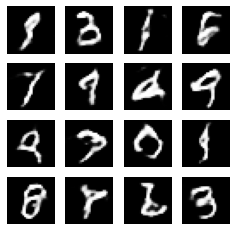

Time for epoch 41 is 125.72218871116638 sec


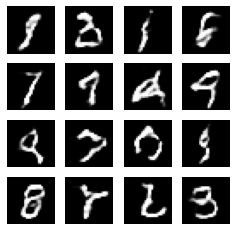

Time for epoch 42 is 125.72379422187805 sec


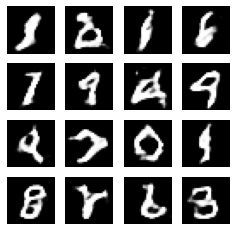

Time for epoch 43 is 125.66485047340393 sec


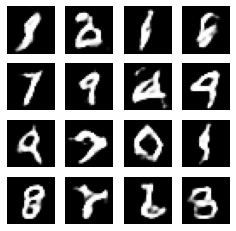

Time for epoch 44 is 125.77461290359497 sec


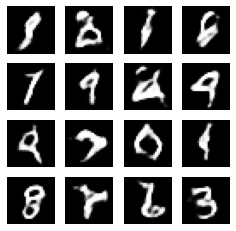

Time for epoch 45 is 125.71076655387878 sec


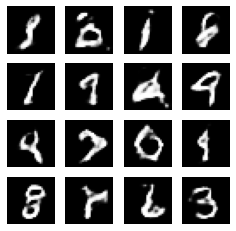

Time for epoch 46 is 125.70580816268921 sec


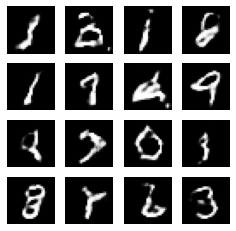

Time for epoch 47 is 125.6993613243103 sec


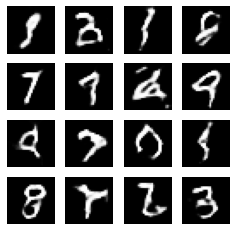

Time for epoch 48 is 125.84485459327698 sec


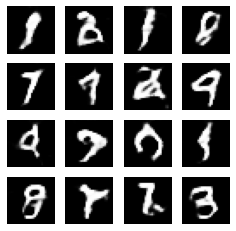

Time for epoch 49 is 125.68630480766296 sec


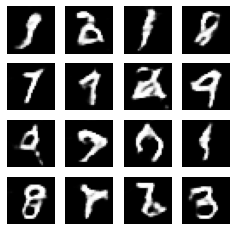

Time for epoch 50 is 125.68961954116821 sec


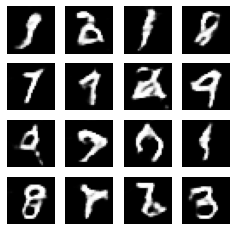

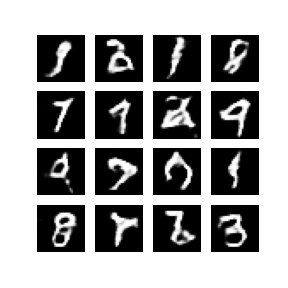

In [70]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
#Training the model
train(train_dataset, EPOCHS)
#restore the latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)
